# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

The goal of this project is to examine a set of job postings with salaries and then predict salaries for a new set of job postings.

In [2]:
#import your libraries
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

#etc

#your info here
__author__ = "Uma Kamatchi"
__email__ = "uma.kamtchi@gmail.com"

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [11]:
#load the data into a Pandas dataframe

#Training Data
features_df=pd.read_csv(r"\Users\Uma\Anacondanew\envs\tensorenviron\Data science projects\data\train_features.csv")
target_df=pd.read_csv(r"\Users\Uma\Anacondanew\envs\tensorenviron\Data science projects\data\train_salaries.csv")
#Testing Data
test_df=pd.read_csv(r"\Users\Uma\Anacondanew\envs\tensorenviron\Data science projects\data\test_features.csv")
   

In [12]:
#view training features data 
features_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [13]:
test_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


In [22]:
#Consolidate training data as jobId is same
train_df=features_df.merge(target_df, on = 'jobId')
train_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [23]:
train_df.shape

(1000000, 9)

### ---- 3 Clean the data ----

In [25]:
#look for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it

#check for duplicate jobID
train_df.drop_duplicates(subset ="jobId", keep = False, inplace = True)
train_df.shape
#No duplicates

(1000000, 9)

In [26]:
#check for invalid data(salaries <=0)
train_df = train_df.drop(train_df[train_df.salary <= 0].index) 
train_df.shape
#shows five data points are <=0

(999995, 9)

In [34]:
#check for missing values 
train_df = train_df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
train_df.info()

#No missing values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999995 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  999995 non-null object
companyId              999995 non-null object
jobType                999995 non-null object
degree                 999995 non-null object
major                  999995 non-null object
industry               999995 non-null object
yearsExperience        999995 non-null int64
milesFromMetropolis    999995 non-null int64
salary                 999995 non-null int64
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


### ---- 4 Explore the data (EDA) ----

In [35]:
#summarizing numerical variable
train_df.describe()



,yearsExperience,milesFromMetropolis,salary
count,999995.000000,999995.000000,999995.000000
mean,11.992407,49.529381,116.062398
std,7.212390,28.877721,38.717163
min,0.000000,0.000000,17.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


In [36]:
#summarize the categorical variable
train_df.describe(include = ['O'])

,jobId,companyId,jobType,degree,major,industry
count,999995,999995,999995,999995,999995,999995
unique,999995,63,8,5,9,7
top,JOB1362684591957,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,1,16193,125886,236975,532353,143205


# Plot the feature

In [51]:
#plotting numerical and categorical variables
def plot_feature(df, col):
    #state the plot size 
    plt.figure(figsize = (12, 6))
    #plot one of two plots 
    plt.subplot(1, 2, 1)
    
    #if column is numeric
    if df[col].dtype == 'int64':
        df[col].value_counts().sort_index().plot()
    else:
        #if column is not numeric then plot the following:
        sns.countplot(x=col, data=df)
        
    #set the labels on the axis 
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel('Counts')
    
    #plot two plot
    plt.subplot(1, 2, 2)
    #if column is numeric then plot the following:
    if df[col].dtype == 'int64':
        mean = df.groupby(col)['salary'].mean()
        mean.plot()
        
    else:
        #if column is not numeric then plot the following:

        sns.boxplot(x = col, y = 'salary', data=df)
        
    #set the labels on the axis    
    plt.xticks(rotation = 45)
    plt.ylabel('Salaries')

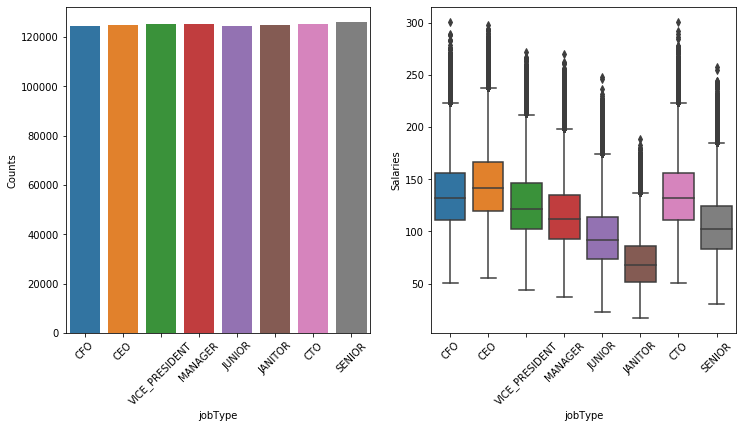

In [52]:
plot_feature(train_df,'jobType')

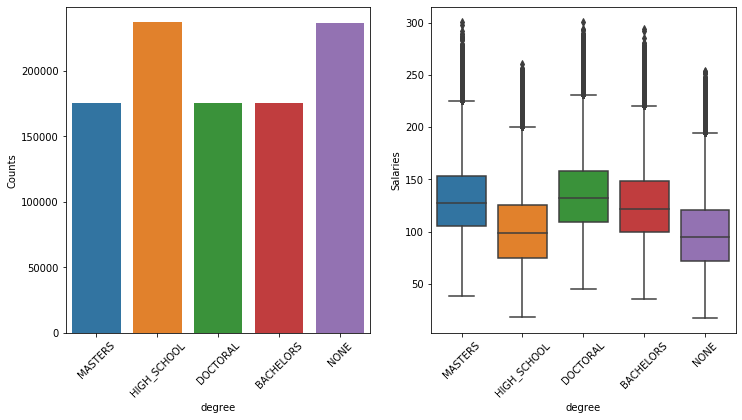

In [53]:
plot_feature(train_df,'degree')
#shows relationship between degree and salaries

# Observation:

In Job types,CEO and CTO shows higher salaries when compared to other job types. 
 High school and None shows lowest salaries when compared to other degrees.

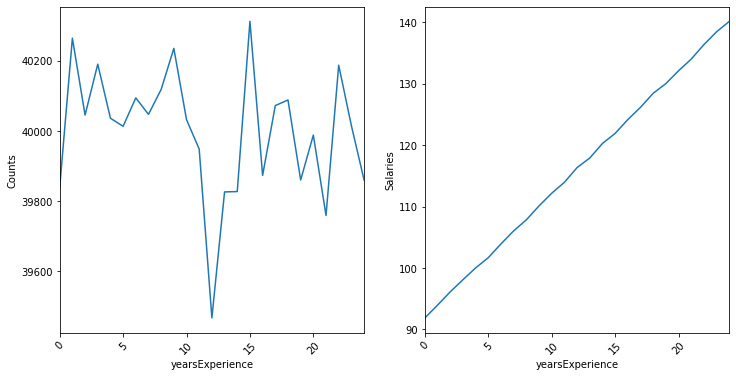

In [61]:
plot_feature(train_df,'yearsExperience')

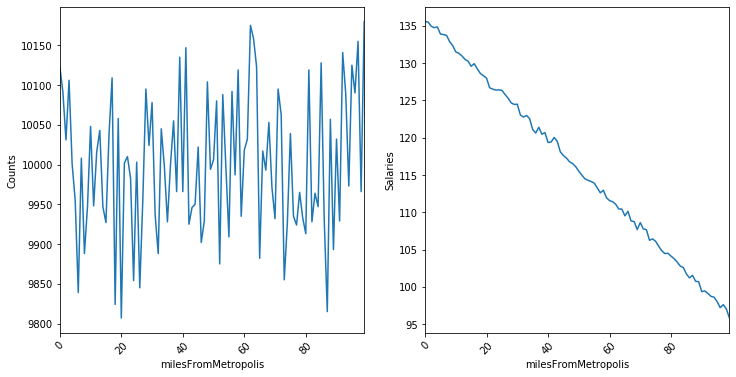

In [62]:
plot_feature(train_df,'milesFromMetropolis')

# Visualize Target Variable

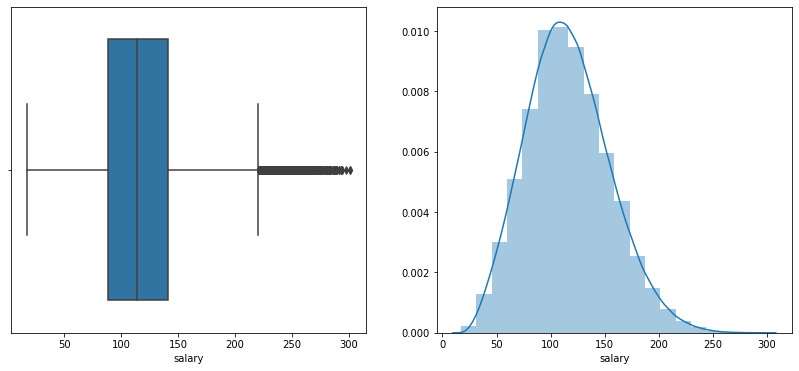

In [60]:
plt.figure(figsize = (14, 6))
plt.subplot(1,2,1)
sns.boxplot(train_df.salary)
plt.subplot(1,2,2)
sns.distplot(train_df.salary, bins=20)
plt.show()

# Correlation

In [65]:
correlated_data = train_df.copy()

In [66]:
# define a function to encode the categorical variables 
def Encode_Data(df):   
    for col in df.columns:        
        if df[col].dtype.name == "category" or "object":
            le = LabelEncoder()
            df[col]=le.fit_transform(df[col])
    return df

In [67]:
#check encoded data
EncodedData = Encode_Data(correlated_data)
EncodedData

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,0,31,1,3,6,3,10,83,113
1,1,11,0,2,7,6,3,73,84
2,2,48,7,1,8,3,10,38,120
3,3,32,5,1,2,0,8,17,125
4,4,60,7,0,8,2,8,16,146
...,...,...,...,...,...,...,...,...,...
999995,999990,52,7,0,2,3,19,94,71
999996,999991,17,2,2,7,2,12,35,143
999997,999992,16,4,2,7,1,16,81,47
999998,999993,23,1,3,7,3,6,5,132


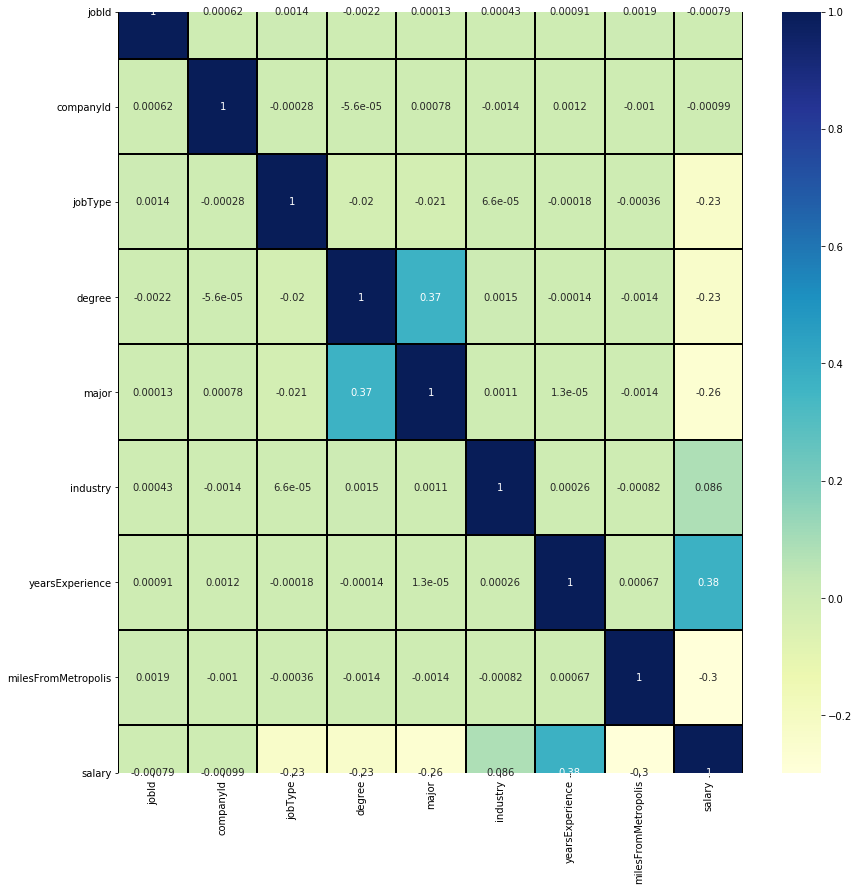

In [72]:
#correlation Matrix
plt.figure(figsize=(14,14))
corr = EncodedData.corr()
sns.heatmap(corr,xticklabels=corr.columns,
            yticklabels=corr.columns,cmap="YlGnBu",annot=True,linewidths=1,linecolor='black')
plt.show()

In [73]:
corr['salary'].sort_values(ascending=False)

salary                 1.000000
yearsExperience        0.375014
industry               0.086500
jobId                 -0.000791
companyId             -0.000993
jobType               -0.228672
degree                -0.231794
major                 -0.262435
milesFromMetropolis   -0.297686
Name: salary, dtype: float64

# Summary:
    

1.Major and degree are highly and positively correlated.
2.Years of Experience is highly correlated with salary(target value)

### ---- 5 Establish a baseline ----

Used Linear Regression as a baseline model with the most correlated features as yearsexperience.

In [75]:
# X and y parameters
x= EncodedData[['yearsExperience']]
y = EncodedData[['salary']]

#using the linear regression method 
modelLR = LinearRegression()

#fitting the model
modelLR.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [77]:
#look at the intercept and coefficent

interceptLR = modelLR.intercept_[0]
coefficientLR = modelLR.coef_[0][0]

print("The intercept for our model is "  + str(interceptLR))
print("The coefficient for our model is "  + str(coefficientLR))

The intercept for our model is 74.92019493794933
The coefficient for our model is 2.0131222573050436


In [80]:
LR_crossval_mse = cross_val_score(modelLR, x, y, scoring = 'neg_mean_squared_error', cv =5)
LR_crossval_mse.mean()

-1288.204605360597

In [5]:
#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy
#e.g. use "average salary" for each industry as your model and then measure MSE
#during 5-fold cross-validation

### ---- 6 Hypothesize solution ----

The baseline model can be improved by using different supervised algorithms like
1.Random Forest ---->Random forest is a collection of decision trees which are randomly trained by nature and easy to
implement. The goal is to aggregate the accuracy of all the trees.It handles overfitting issues by reducing variance and independent classifiers.
2.Gradient Boosting Algorithms------> combines weakly coorelated fetures into a single strong learner.

## Part 3 - DEVELOP

In [89]:
Traindata = correlated_data.copy()
Traindata

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,0,31,1,3,6,3,10,83,113
1,1,11,0,2,7,6,3,73,84
2,2,48,7,1,8,3,10,38,120
3,3,32,5,1,2,0,8,17,125
4,4,60,7,0,8,2,8,16,146
...,...,...,...,...,...,...,...,...,...
999995,999990,52,7,0,2,3,19,94,71
999996,999991,17,2,2,7,2,12,35,143
999997,999992,16,4,2,7,1,16,81,47
999998,999993,23,1,3,7,3,6,5,132


# ---- 7 Engineer features  ----

In [90]:
Traindata = Traindata.drop(columns =['jobId', 'companyId'])
Traindata

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,1,3,6,3,10,83,113
1,0,2,7,6,3,73,84
2,7,1,8,3,10,38,120
3,5,1,2,0,8,17,125
4,7,0,8,2,8,16,146
...,...,...,...,...,...,...,...
999995,7,0,2,3,19,94,71
999996,2,2,7,2,12,35,143
999997,4,2,7,1,16,81,47
999998,1,3,7,3,6,5,132


In [91]:
target = Traindata['salary']
features = Traindata.drop('salary',axis=1)

### ---- 8 Create models ----

In [15]:
#create and tune the models that you brainstormed during part 2

In [ ]:
#initialize model list and dicts
models = []
mean_mse = {}
cv_std = {}

In [92]:
x = features
y = target
#splitting datasets

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2)

In [93]:
LR = LinearRegression()
RF = RandomForestRegressor(n_estimators=200, n_jobs=4, max_depth=30, 
                           min_samples_split=60, max_features='auto', verbose=0)
GB = GradientBoostingRegressor(n_estimators=160, max_depth=6, loss='ls',verbose=0)

In [96]:
def training_model(model,x_train,y_train, mean_mse, cv_std):
    print('\033[1m'+ 'Model Name: \n' + '\033[0m',model)
    neg_mse= cross_val_score(model,x_test,y_test,cv=5,scoring='neg_mean_squared_error')
    mean_mse[model] = np.mean(neg_mse)
    cv_std[model] = np.std(neg_mse)
    print('\033[1m' + 'Average Negative Mean Squared Error:\n' + '\033[0m', mean_mse[model])
    print('\033[1m' + 'Standard Deviation:\n' + '\033[0m', cv_std[model])

# ---- 9 Test models ----

In [97]:
#Evaluate models with 5 fold cross validation
models.extend([LR,RF,GB])
for model in models: 
    training_model(model, x_train, y_train, mean_mse, cv_std)

Model Name: 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Average Negative Mean Squared Error:
 -921.9250179032766
Standard Deviation:
 4.276083104201371
Model Name: 
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=60,
                      min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=4,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)
Average Negative Mean Squared Error:
 -388.551020451769
Standard Deviation:
 2.1235002808590546
Model Name: 
 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=6,
                          max_features=None, max_leaf_nodes=None,
                 

### ---- 10 Select best model  ----

In [100]:
#select the model with the lowest error as your "prodcuction" model
#use max function because using negative MSE and therefore want it as big as possible
bestmodel = max(mean_mse, key=mean_mse.get) 
print('\nBest model is: \n', bestmodel)


Best model is: 
 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=6,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=160,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [107]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset
bestmodel.fit(x,y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=6,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=160,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [108]:
#checking test data
test_df.dtypes

jobId                  int32
companyId              int32
jobType                int32
degree                 int32
major                  int32
industry               int32
yearsExperience        int64
milesFromMetropolis    int64
dtype: object

In [109]:
#explore test data
test_df.shape

(1000000, 8)

In [110]:
#Encode Categorical data
Encode_Data(test_df)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,0,27,5,2,7,3,22,73
1,1,5,4,4,7,0,20,47
2,2,2,2,3,0,3,17,9
3,3,14,5,2,7,4,14,96
4,4,30,4,1,0,4,10,44
...,...,...,...,...,...,...,...,...
999995,999995,50,7,0,6,4,14,3
999996,999996,45,5,4,7,3,20,67
999997,999997,58,3,4,7,4,1,91
999998,999998,11,2,1,6,4,14,63


In [111]:
#Drop jobId and companyID
Testdata = test_df.drop(columns=['jobId', 'companyId'],axis=1)
Testdata

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,5,2,7,3,22,73
1,4,4,7,0,20,47
2,2,3,0,3,17,9
3,5,2,7,4,14,96
4,4,1,0,4,10,44
...,...,...,...,...,...,...
999995,7,0,6,4,14,3
999996,5,4,7,3,20,67
999997,3,4,7,4,1,91
999998,2,1,6,4,14,63


In [112]:
#predict model
predictions = bestmodel.predict(Testdata)
predictions

array([ 93.50706571,  75.56334577, 164.5277813 , ...,  38.46937575,
       145.86821008,  96.94982204])

### ---- 12 Deploy solution ----

In [113]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
Testdata['Salary Predictions'] = predictions.tolist()

In [114]:
Testdata.to_csv(r'Salary Prediction.csv', index = False)

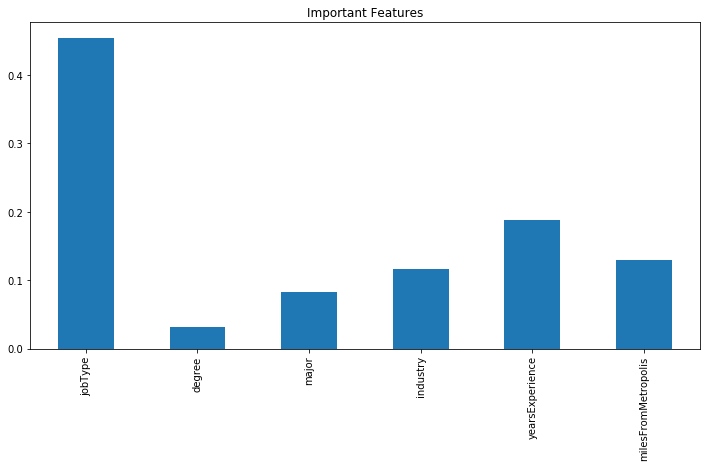

In [120]:
importances = pd.Series(bestmodel.feature_importances_,index=features.columns)
importances.plot(kind='bar', figsize=(12,6))
plt.title("Important Features")
plt.savefig('Imortant Features.png')
plt.show()